In [1]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme("chesterish")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
!pip install tensorflow

  Using cached tensorflow-2.5.0-cp38-cp38-win_amd64.whl (422.6 MB)
  Using cached h5py-3.1.0-cp38-cp38-win_amd64.whl (2.7 MB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
textract 1.6.3 requires six==1.12.0, but you have six 1.15.0 which is incompatible.


  Using cached tensorboard-2.5.0-py3-none-any.whl (6.0 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tensorflow_estimator-2.5.0-py2.py3-none-any.whl (462 kB)
  Using cached grpcio-1.34.1-cp38-cp38-win_amd64.whl (2.9 MB)
  Using cached keras_nightly-2.5.0.dev2021032900-py2.py3-none-any.whl (1.2 MB)
  Using cached Markdown-3.3.4-py3-none-any.whl (97 kB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0


In [1]:
#for data analysis and modeling
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential, model_from_json
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
#for text cleaning
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#for visualization
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('filtered.csv')

In [3]:
df.shape

(318113, 9)

In [4]:
df = df[df['tweet'].apply(lambda x: isinstance(x, str))]
# df = df[df['injury_report']!='x']
df = df[['injury_report','tweet']]

In [5]:
df

,injury_report,tweet
0,0,"Mets Game 81 of 162, vs. MIL Monday, July 5, 7..."
1,0,@Blyzzard211 That is 100% an organizational ph...
2,0,"@rmazzochi Sounds like this weekend, unless th..."
3,0,@EddieEddington2 The final eight weeks of 2015.
4,0,@alexdeejames Not weird. Manny Machado was a b...
...,...,...
318108,x,"Fook Lam Moon Restaurant; Newman House, Johnst..."
318109,x,"Sabor Nordestino; Av. Barão de Vera Cruz, 10 -..."
318110,x,"Bingo Pizza Kwatta; Kwattaweg 296, Paramaribo,..."
318111,x,"Poki Yaki; Garapan, Saipan 96950, CNMI https:..."


## New implementation, don't look at this as dataframes have been changed

In [6]:
df1 = df[df['injury_report']!='x']
df2 = df[df['injury_report']=='x']

In [8]:
# %%time
def clean_text(txt):
    """""
    cleans the input text in the following steps
    1- replace contractions
    2- removing punctuation
    3- spliting into words
    4- removing stopwords
    5- removing leftover punctuations
    """""
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    # replace contractions
    txt = replace_contractions(txt)
    
    #remove punctuations
    txt  = "".join([char for char in txt if char not in string.punctuation])
    txt = re.sub('[0-9]+', '', txt)
    
    # split into words
    words = word_tokenize(txt)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    # removing leftover punctuations
    words = [word for word in words if word.isalpha()]
    
    cleaned_text = ' '.join(words)
    return cleaned_text
    
df1['data_cleaned'] = df1['tweet'].apply(lambda txt: clean_text(txt))
df2['data_cleaned'] = df2['tweet'].apply(lambda txt: clean_text(txt))

<ipython-input-8-66deda73dc7a>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['data_cleaned'] = df1['tweet'].apply(lambda txt: clean_text(txt))
<ipython-input-8-66deda73dc7a>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['data_cleaned'] = df2['tweet'].apply(lambda txt: clean_text(txt))


In [9]:
df1['data_cleaned']

0         Mets Game vs MIL Monday July pm RHP Brandon Wo...
1         Blyzzard That organizational philosophy unique...
2         rmazzochi Sounds like weekend unless Mets deci...
3                      EddieEddington The final eight weeks
4         alexdeejames Not weird Manny Machado big comp ...
                                ...                        
239308    Posey essentially day day team bring IL ready ...
242107    Update RHP TK Roby right elbow sprain Dr Jeffr...
243383       Castellanos game HBP Aristedes Aquino takes RF
243621    Todays IronPigs transactions RHP Adonis Medina...
246372                                       httpstcolRZbAS
Name: data_cleaned, Length: 2105, dtype: object

In [11]:
df1['data_cleaned'].shape

(2105,)

In [10]:
df2['data_cleaned']

1938      Even offense sputtering way imagine Giants thr...
1939      Jack Flaherty joined team San Francisco today ...
1940      Thank Always much fun hop radio show I listene...
1941                                        RussDorsey So I
1942                                        httpstconRNbNJe
                                ...                        
318108    Fook Lam Moon Restaurant Newman House Johnston...
318109    Sabor Nordestino Av Barão de Vera Cruz Cruz de...
318110    Bingo Pizza Kwatta Kwattaweg Paramaribo Surina...
318111    Poki Yaki Garapan Saipan CNMI httpstcoftfPociI...
318112    Zanzibar Rue Jean Jaurès Nouméa New Caledonia ...
Name: data_cleaned, Length: 315933, dtype: object

In [12]:
df2['data_cleaned'].shape

(315933,)

## Old implementation (results shared were of this implementation)

In [34]:
df[df['injury_report']=='1']

,injury_report,tweet
53,1,"Sean Reid-Foley heads to the IL, plus other Me..."
61,1,Yenssy Díaz is now active. Sean Reid-Foley hea...
80,1,A nice return from the injured list for Jeurys...
93,1,Brandon Nimmo with a three-hit day in his firs...
99,1,@UltiMetWarrior Back injury. He'll be out a wh...
...,...,...
239308,1,Posey is essentially day to day too - team wil...
242107,1,Update on RHP TK Roby (right elbow sprain) “Dr...
243383,1,Castellanos is out of the game now after that ...
243621,1,Today's @IronPigs transactions: RHP Adonis Med...


In [35]:
df1['injury_report'] = df1['injury_report'].astype(int)

<ipython-input-35-735004da46ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['injury_report'] = df1['injury_report'].astype(int)


In [36]:
df1.dtypes

injury_report     int32
tweet            object
data_cleaned     object
dtype: object

In [37]:
df1.to_csv('labeled data.csv')
df2.to_csv('unlabeled data.csv')

## Train test split

In [38]:
xtrain, xtest, ytrain, ytest = train_test_split(df1['data_cleaned'], df1['injury_report'], shuffle=True, test_size=0.2)
# find the length of the largest sentence in training data
max_len = xtrain.apply(lambda x: len(x)).max()
print(f'Max number of words in a text in training data: {max_len}')

Max number of words in a text in training data: 229


In [39]:
max_words = 10000
tokenizer = text.Tokenizer(num_words = max_words)
# create the vocabulary by fitting on x_train text
tokenizer.fit_on_texts(xtrain)
# generate the sequence of tokens
xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xtest_seq = tokenizer.texts_to_sequences(xtest)

# pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)
word_index = tokenizer.word_index

# print('text example:', xtrain[0])
print('sequence of indices(before padding):', xtrain_seq[0])
print('sequence of indices(after padding):', xtrain_pad[0])

sequence of indices(before padding): [818, 1366, 237, 198, 474, 215, 177, 443, 1, 41, 1367, 2593, 2594, 16, 1127, 117, 2595, 2596, 259, 237, 198, 280, 444, 1128, 2597]
sequence of indices(after padding): [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0

In [1]:
%%time
embedding_vectors = {}
# with open('/kaggle/input/glove6b100d/glove.6B.100d.txt','r',encoding='utf-8') as file:
with open('glove.42B.300d.txt','r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")   

NameError: name 'np' is not defined

In [41]:
#initialize the embedding_matrix with zeros
emb_dim = 300
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)
#print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:5]}')

Some out of valubulary words: ['tworun', 'cronenworth', 'stlcards', 'kiké', 'threerun']


In [32]:
print(f'{oov_count} out of {vocab_len} words were OOV.')

784 out of 10000 words were OOV.


## Following was the result for Out of vocab words

In [17]:
oov_words = ['tworun',
 'cronenworth',
 'stlcards',
 'kiké',
 'threerun',
 'haseong',
 'gurriel',
 'espnstatsinfo',
 'rightcenter',
 'twoout',
 'pinchhit',
 'extrabase',
 'gametying',
 'covid',
 'caratini',
 'franmil',
 'pcbb',
 'markzuckerman',
 'woosox',
 'httpstcooybycvb',
 'ohtanis',
 'oneout',
 'alexdeejames',
 'viatorlion',
 'altuves',
 'journalsentinel',
 'degroms',
 'tombiersdorfer',
 'covidrelated',
 'threehit',
 'nashvillesounds',
 'raisel',
 'nohitter',
 'onerun',
 'urshela',
 'infof',
 'urquidy',
 'mhatter',
 'johnjiris',
 'firstinning',
 'kimjonessports',
 'ramirezs',
 'pinchhitter',
 'dinelson',
 'lindseyadler',
 'hankj',
 'suckafreeon',
 'crismatt',
 'fiverbi',
 'minorleague',
 'waynerandazzo',
 'aampm',
 'guillorme',
 'lindors',
 'thejimmyfund',
 'richardstaff',
 'tatís',
 'seriousjammage',
 'fabianardaya',
 'threegame',
 'roundrocktim',
 'joeymachockey',
 'enoli',
 'mikeirace',
 'httpstcobvgsgrfj',
 'astroswhite',
 'suarezs',
 'httpstcokmtpapcd',
 'senzatela',
 'seveninning',
 'sixrun',
 'moneymike',
 'fourtime',
 'httpstcovyntpyzozi',
 'httpstcopajbnhaz',
 'todddybas',
 'talknats',
 'montessi',
 'sixman',
 'extrainning',
 'bigbussy',
 'httpstcorxerbyfpd',
 'perazas',
 'httpstcoemxutdbdu',
 'joshstros',
 'httpstcoaocjedbwl',
 'stromans',
 'megills',
 'deeshathosar',
 'httpstcomvwqjbreop',
 'backpageguynydn',
 'zachmweber',
 'antetokounmpo',
 'markasaxon',
 'domfrederic',
 'philhand',
 'httpstcojolkeowkt',
 'oswalts',
 'shortporch',
 'sschreiber',
 'seasonhigh',
 'simonwdc',
 'httpstcodfjlqlqzuh',
 'multihr',
 'martinopuccio',
 'httpstcoxunlenmen',
 'dpyoung',
 'knizner',
 'cubtogether',
 'fourgame',
 'lfnjsinner',
 'julybeginning',
 'franchy',
 'httpstcotfsmhvnrb',
 'ohtaniexitvelowatch',
 'httpstcoxxznjkcs',
 'carrascos',
 'eddieeddington',
 'srlyujest',
 'garbagekatt',
 'dgoold',
 'secondmost',
 'aledmys',
 'heelankle',
 'httpstcofjhooq',
 'mattkalman',
 'loaisiga',
 'rysheeds',
 'nutsand',
 'httpstcobktfegxwwg',
 'eightyear',
 'quinnrileybsw',
 'cjcerda',
 'httpstcoxpoazmzkbw',
 'httpstcoanfrabs',
 'astrosindians',
 'almoras',
 'nonbaseball',
 'reidfoley',
 'turfburner',
 'astrosfuture',
 'sadlersquared',
 'gofrogs',
 'httpstcocjnldsitr',
 'httpstcozgvyevkw',
 'yenssy',
 'renés',
 'basesloaded',
 'letsgomets',
 'httpstcoeacwbg',
 'viscilyii',
 'karinchak',
 'nohit',
 'gogogadgetbaton',
 'peterjpierce',
 'rubberducks',
 'httpstcoeyxrfbv',
 'szapucki',
 'cardinalsgiants',
 'httpstcoufzxldhjp',
 'twelveplus',
 'nonnational',
 'httpstcouamvhrcog',
 'billballoutg',
 'kentuckinnati',
 'groundrule',
 'sdnomad',
 'httpstcoplgthvgeaq',
 'extrainnings',
 'httpstcoahtdvif',
 'httpstcorweszavgk',
 'downwithskynet',
 'httpstcojndlcsmod',
 'midseven',
 'timbhealey',
 'quantrills',
 'httpstcoiyhgrid',
 'lorenzodostuff',
 'halfishmane',
 'httpstcousecbxscx',
 'straightuptx',
 'hardesthit',
 'paysonaztim',
 'latimessports',
 'httpstcocwymxip',
 'mlbdream',
 'restrictionscomplications',
 'httpstcowwzdyxa',
 'httpstcoaqylya',
 'eighthinning',
 'shildt',
 'optimstic',
 'jorgecastillo',
 'jjankowski',
 'scolemanlu',
 'httpstcokpzhebllqk',
 'rcarlson',
 'dougscherer',
 'httpstcohcknwvl',
 'guywhen',
 'raininduced',
 'slimcliffy',
 'httpstcoqljjfovtv',
 'degromsleftsock',
 'httpstcoamvldf',
 'httpstcowfqrisszl',
 'httpstcobaswvomh',
 'notsofree',
 'waltersbardc',
 'bigleague',
 'workevader',
 'greinkes',
 'luvzbake',
 'superexciting',
 'thairo',
 'httpstcoqlgrsfrss',
 'bdriesdm',
 'blyzzard',
 'httpstcofswflhrlv',
 'httpstcoqlopjehb',
 'madinstl',
 'httpstcojbeekiad',
 'crazycubsguy',
 'httpstcopxpajcwr',
 'httpstcoihtqglqn',
 'chadjenningss',
 'httpstcosysrfqgeas',
 'httpstcouanaikq',
 'sogards',
 'midsix',
 'tonymeza',
 'theamandaroast',
 'odorizzis',
 'httpstcomzuqpztre',
 'sixthconsecutive',
 'doubleswitch',
 'httpstcouhhemkokmd',
 'httpstcoswvtt',
 'thevirk',
 'midjuly',
 'earlymid',
 'httpstconttzgjaba',
 'httpstcoxnhlbkov',
 'jjak',
 'therfreeman',
 'hoyers',
 'pretommy',
 'httpstcoavtllcv',
 'statmastersteve',
 'httpstcotqbjvhobuk',
 'howertonjoe',
 'httpstcoascwiae',
 'mikemaher',
 'httpstcozbckrwyak',
 'httpstcovqamdgzxty',
 'httpstcolskoyhuhlp',
 'httpstcohxwgtanuo',
 'httpstcoiqerxofdx',
 'fneyeno',
 'httpstcozlacsbbvo',
 'patclancy',
 'httpstcozxxynzbcbf',
 'eovadi',
 'spchrishatfield',
 'httpstcoxjjbbmchd',
 'httpstcohodvihcs',
 'ryanrufe',
 'fantasyrath',
 'scottyballgame',
 'httpstcoeeqhoav',
 'sammylev',
 'httpstcohjydmgmmz',
 'httpstcofpefxuiv',
 'httpstcoqpfdci',
 'threestart',
 'brettbibbinsksr',
 'httpstcootqvwsp',
 'httpstconckazecj',
 'httpstcoiyqiqkwld',
 'higashiokas',
 'gameending',
 'soulex',
 'httpstcoejtwkequ',
 'bradfo',
 'glasnow',
 'stirkeout',
 'kraigwithak',
 'httpstcoizzhvwfp',
 'chelseajanes',
 'chelseafactor',
 'márquezs',
 'mikefenton',
 'joanniesen',
 'httpstcovmpxxpjt',
 'houstondynamo',
 'httpstcolfpajajgoi',
 'escy',
 'kebryan',
 'httpstcoljrxxmbv',
 'presidentgeneral',
 'servideo',
 'httpstcoatrkrmwgvn',
 'httpstcowhsbsorlm',
 'juhltrucker',
 'httpstcozubhxyqxp',
 'httpstcocjzmdbeph',
 'httpstcojswmhlpsd',
 'superclutch',
 'httpstcorehmikl',
 'howardagnew',
 'httpstcokidbidybfp',
 'updowns',
 'kozybbq',
 'httpstcostagoshvrj',
 'nypostmets',
 'postdelay',
 'httpstcochmoqr',
 'httpstcorgnrfcv',
 'thecincyintake',
 'comefrombehindwin',
 'httpstcoipueq',
 'faninterference',
 'notsopromising',
 'httpstcoilfigrzsg',
 'httpstcolivvtsbkg',
 'ricmister',
 'dylanobrien',
 'httpstcoeodfzk',
 'httpstcomvtadhhp',
 'ajmcdonald',
 'legalbevo',
 'tonyrbranco',
 'pinchhits',
 'gripcommand',
 'mantognoli',
 'thelittlethings',
 'mroberson',
 'ncneil',
 'httpstcotmntnyuc',
 'httpstcocktkqzyk',
 'cfoster',
 'nimmos',
 'papierski',
 'knehr',
 'brianhavrilla',
 'httpstcoxdbzbbnqt',
 'httpstconizbtcjet',
 'pitchersduel',
 'odúbel',
 'millmanner',
 'gregrajan',
 'httpstcoufmokkcjh',
 'httpstcogiszsjvjz',
 'httpstcoavkdaujtnm',
 'httpstcobdpsfhbok',
 'mlbleading',
 'japaneseborn',
 'httpstcozidvujv',
 'casabonita',
 'httpstcofccvrjeej',
 'jshappell',
 'nonman',
 'nycuconn',
 'httpstcoubwfmxgyw',
 'httpstcobuzlauoeb',
 'aalonsoftw',
 'benvarela',
 'httpstcoogukwfar',
 'httpstcoqbfosbj',
 'toomuchmortons',
 'pmmjr',
 'loupon',
 'httpstcorgjryshhbn',
 'ohtanimania',
 'httpstcobopsgqxes',
 'ninegame',
 'threebatter',
 'httpstcobrinetjpih',
 'httpstcorpukiwxw',
 'jgrossman',
 'dskolnick',
 'hernándezs',
 'httpstcopajbgjr',
 'aignerd',
 'badersback',
 'httpstcorfylued',
 'httpstcoibyciuiysy',
 'ndlongest',
 'jschillmaier',
 'steveperrault',
 'harwichmariners',
 'officialccbl',
 'padresd',
 'httpstcoobsqqgejj',
 'bobbycressey',
 'httpstcoyuuepvgfyi',
 'injuryabsence',
 'httpstcomkcczzw',
 'fraingarza',
 'cardsastros',
 'httpstcobpvlcu',
 'httpstcokfnuehsrh',
 'mgigga',
 'zippytms',
 'reinerhoward',
 'juniorpepen',
 'doubleswitched',
 'nancynymnygnyr',
 'fiverun',
 'httpstcotqkorpk',
 'httpstcowkjlikozs',
 'careerlong',
 'cardinalsin',
 'doubleswitches',
 'kevinnnn',
 'commandcontrol',
 'httpstcoxunlebnf',
 'httpstcoiymhsldkup',
 'maxairhead',
 'chickludwig',
 'httpstcoemcbnylaf',
 'umpscorecards',
 'lminmd',
 'swingmiss',
 'seriusmatticus',
 'ramstw',
 'httpstcoxgshcvthy',
 'ninepitch',
 'minibreakthrough',
 'brokenbat',
 'midfive',
 'httpstcotuvtgswra',
 'httpstcokgjzotqw',
 'httpstcornjlvrrk',
 'emmacaustin',
 'goodpieceofhitting',
 'cobywankanobi',
 'sonot',
 'jwman',
 'bwdbwdbwd',
 'httpstcolsyhkswt',
 'majorleague',
 'shornet',
 'bodegabrother',
 'betmgm',
 'mikepetriello',
 'httpstcovgbfcqz',
 'bdole',
 'brothersinlaw',
 'joshcox',
 'movethesticks',
 'httpstcoccfvzfcxb',
 'yeison',
 'httpstcojpoknpsdzg',
 'httpstcoznrmzxciu',
 'eightyseven',
 'dainerrr',
 'cardiled',
 'lilobets',
 'httpstcodvzlpbnr',
 'cronenworthtatis',
 'judahbrody',
 'zachsilver',
 'katiewoo',
 'playersmanagersgms',
 'jpmarino',
 'httpstcojuwvmbai',
 'mweldon',
 'threedouble',
 'twohole',
 'httpstcojjqckt',
 'longrelief',
 'httpstcodowrcrth',
 'dogearedcarrie',
 'winjury',
 'httpstcoruvgfmjp',
 'httpstcoyylrnathw',
 'umiamihealth',
 'httpstcodzluqs',
 'httpstcovainnkzlz',
 'httpstcoclczbwz',
 'abthefriar',
 'paddacks',
 'httpstcounbbxsvnf',
 'httpstcocxrxwbvb',
 'neojudai',
 'renfroes',
 'httpstcoavsqchlp',
 'httpstcowldyrjtqx',
 'shaunrainey',
 'anaheimla',
 'httpstcolzfwjdnof',
 'threestrikeout',
 'westcoastbias',
 'httpstcoangeyysjue',
 'httpstcoomsljiujk',
 'dohyoungpark',
 'twoplus',
 'trevparkford',
 'httpstcopcffqcmka',
 'httpstcoyspmmkrto',
 'friarstilwedie',
 'httpstcoebcwhixu',
 'httpstcohwtecmxtk',
 'mrhappyonabike',
 'playbyplay',
 'httpstcothkapqywo',
 'johnquinn',
 'twoouts',
 'hosmers',
 'httpstcozabilvel',
 'urías',
 'httpstcoopzvedtivt',
 'httpstcosfuugdblpi',
 'httpstcoypnxxxjdo',
 'ncolby',
 'payservice',
 'daverite',
 'asdrúbal',
 'httpstcorabdpkx',
 'httpstcowenqeqvh',
 'httpstcocijelaolz',
 'squadup',
 'httpstcotxvqwwuk',
 'httpstcortxaenpbd',
 'httpstcoybpcjcsvv',
 'httpstcoorwvrmtqo',
 'httpstcovssxcsdcwb',
 'stlouilmette',
 'semidelirious',
 'quanteberry',
 'jeffhan',
 'httpstcobdqdjxhx',
 'theradiomike',
 'bethunecookman',
 'collegeutah',
 'forceholy',
 'httpstcoqqxypos',
 'ultimetwarrior',
 'multiibb',
 'byrobertmurray',
 'tepera',
 'laterdid',
 'mschwartz',
 'dellatora',
 'divisionleading',
 'httpstcowjmgqdao',
 'nohitting',
 'mattymatty',
 'megglennn',
 'tommykeavy',
 'httpstcowhnesioes',
 'httpstcodzykotpz',
 'middlemiddle',
 'httpstcovvfzksd',
 'httpstcodfsnngwrp',
 'ericstreight',
 'httpstcoaraxqcwr',
 'fakesportsbar',
 'httpstcoxjwnkqeltz',
 'bregmans',
 'mannyonmlb',
 'mlbnetwork',
 'sfunitencali',
 'kensky',
 'pedroias',
 'httpstcoccjjxeol',
 'marksantana',
 'hernandezs',
 'dowlslife',
 'oriolestigers',
 'russellwing',
 'oppositefield',
 'httpstcojapiysbx',
 'poloascencio',
 'httpstcokdmxetafjg',
 'httpstcoeknfjyxnv',
 'phamiliar',
 'httpstcoyxhzxsx',
 'tueswedthurs',
 'httpstcoqqxygyzq',
 'bylindsayhjones',
 'aztecspadresvgk',
 'httpstcobmwvgsyj',
 'qnjastros',
 'planhope',
 'damiencollado',
 'httpstcosveqyqwim',
 'httpstcogcoiwcaufz',
 'jacksonstuart',
 'coreyastewart',
 'fourrun',
 'threehomer',
 'mccormickrf',
 'httpstcobwhaoywyw',
 'fffjayare',
 'httpstcoazoucotg',
 'fastrising',
 'augsept',
 'httpstcolzvxdtfw',
 'stringslife',
 'teaguesenninger',
 'grishammyerstatismateo',
 'andrieses',
 'sevenman',
 'buffalobisons',
 'httpstcofmupjsz',
 'httpstcompkwurmfz',
 'httpstcowsfqglkczc',
 'annieheilbrunn',
 'httpstcowidkbepej',
 'seasonandahalf',
 'httpstcoezqvuethj',
 'nodoubter',
 'cronenworths',
 'coolstat',
 'kylebrostowitz',
 'astrosas',
 'statcast',
 'thirdfastest',
 'evanrvice',
 'justdelossantos',
 'httpstcozewbuoisw',
 'httpstconjcpbaq',
 'httpstcojvvetvkryx',
 'nogowskis',
 'httpstcockrwljxi',
 'httpstcoldkhoze',
 'mvpbojack',
 'tannersoderberg',
 'mikevassallo',
 'kleinschmidtjd',
 'salcastaneda',
 'httpstcoashuvwxdp',
 'midthree',
 'httpstcosnixm',
 'httpstcoxiluxpaoiw',
 'douglesmerises',
 'httpstcoktwgpllxc',
 'teoscar',
 'adammccalvy',
 'afterwardsthe',
 'httpstcojpckyoy',
 'blacksqrrl',
 'jefferickson',
 'jongreenberg',
 'nerdtrea',
 'httpstcobrgamyhzx',
 'baronelijoe',
 'httpstcoecakrbsgdy',
 'httpstcozmnqhmz',
 'brantleys',
 'httpstcokrthnczyku',
 'vesia',
 'httpstcopmddgsir',
 'httpstcomvwnoeanh',
 'sixgame',
 'katterrell',
 'comefrombehind',
 'pitchforkworthy',
 'olshin',
 'httpstcorvdwfmirqx',
 'halfinning',
 'roeblingon',
 'meatheadreds',
 'pinchhitting',
 'httpstcorzieufuhk',
 'sixpitch',
 'lamets',
 'httpstcouoxsxibfrm',
 'httpstconckazvgbj',
 'httpstcoqytmvzva',
 'positionplayer',
 'httpstcotcqyuetfbo',
 'highleverage',
 'httpstcokknrnbaq',
 'darwinzon',
 'soxuals',
 'mnpaleocons',
 'illprepared',
 'cealeygodwin',
 'highlydesired',
 'httpstcobwnarumqnl',
 'httpstcovbtwswvw',
 'donnieb',
 'httpstcogzaesyiwgd',
 'nuckchorris',
 'midinning',
 'rainsoaked',
 'tatismania',
 'httpstcoyowloqfsz',
 'enriquerojas',
 'ramirezrylen',
 'httpstcorcfnsgxypx',
 'httpstcowstczjqgp',
 'httpstcocogfjtqt',
 'multitime',
 'httpstcoldsamglfv',
 'aenguso',
 'httpstcofzodfcsru',
 'nnoyingpadrefan',
 'httpstcokbbdsegf',
 'benverlander',
 'jethrow',
 'rizzosburner',
 'thecommish',
 'postdispatch',
 'appropriatelynamed',
 'johnnydblakley',
 'ashleybastock',
 'httpstcosccihqveo',
 'hirua',
 'httpstcofiwgfowtn',
 'orangefire',
 'gausmans',
 'httpstcopgbujgfci',
 'httpstcowcubvpz',
 'hitbypitch',
 'joeywright',
 'kocherk',
 'fiveman',
 'gleyber',
 'httpstcorweszaesa',
 'therallymullet',
 'gaulpeorge',
 'httpstcolnjsjadqe',
 'willwoodruff',
 'innout',
 'magnemightiest',
 'rjoequinn',
 'redsoxangels',
 'httpstconaqvrkka',
 'backandforth',
 'httpstcoayldmjgtb',
 'eickoff',
 'httpstcoidmpnth',
 'scrantonwilkesbarre',
 'minirally',
 'nineinning',
 'midone',
 'baseballsky',
 'httpstcoipllnsamt',
 'httpstcoomcrpcdvi',
 'httpstcoxbimftrri',
 'thirdround',
 'httpstcovguuqubqvl',
 'httpstcockecjqtiz',
 'degreelaunchangle',
 'eovaldis',
 'romineinjured',
 'woltersdfa',
 'againinjured',
 'higginsinjured',
 'lobatoninjured',
 'gushuecurrentmlb',
 'jsprague',
 'halodadslfl',
 'httpstcotuvtgkj',
 'elmccaffrey',
 'iandon',
 'balpit',
 'rosterlineup',
 'soonishhard',
 'recordtying',
 'httpstcomhgcftltfa',
 'anthonydicomo',
 'bourbonsooners',
 'benslack',
 'wiecks',
 'strikeemoutthrow',
 'emout',
 'httpstcoytnuscie',
 'darrengarrett',
 'lndspatterson',
 'russojackson',
 'brobertschultz',
 'theathletic',
 'httpstcoaebsaqvp',
 'dcwash',
 'httpstcopmdcyqtr',
 'astrosorioles',
 'httpstcoyfdlleojp',
 'ajzahn','tleftist']

In [18]:
i = 0
for word in oov_words:
    if(word[:4] == 'http'):
        i+=1
print(i)

243


## LSTM Model

In [34]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation = 'sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,219,777
Trainable params: 219,777
Non-trainable params: 3,000,000
_________________________________________________________________
None


In [35]:
%%time
batch_size = 256
epochs  = 10
history = lstm_model.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)

Epoch 1/10
7/7 [==============================] - 62s 2s/step - loss: 0.5321 - accuracy: 0.7482 - val_loss: 0.3994 - val_accuracy: 0.8694
Epoch 2/10
7/7 [==============================] - 9s 1s/step - loss: 0.4112 - accuracy: 0.8593 - val_loss: 0.3439 - val_accuracy: 0.8741
Epoch 3/10
7/7 [==============================] - 9s 1s/step - loss: 0.3616 - accuracy: 0.8682 - val_loss: 0.3196 - val_accuracy: 0.8836
Epoch 4/10
7/7 [==============================] - 9s 1s/step - loss: 0.3170 - accuracy: 0.8771 - val_loss: 0.2781 - val_accuracy: 0.8860
Epoch 5/10
7/7 [==============================] - 11s 2s/step - loss: 0.2493 - accuracy: 0.9014 - val_loss: 0.2212 - val_accuracy: 0.9121
Epoch 6/10
7/7 [==============================] - 10s 1s/step - loss: 0.2059 - accuracy: 0.9216 - val_loss: 0.2077 - val_accuracy: 0.9240
Epoch 7/10
7/7 [==============================] - 10s 1s/step - loss: 0.1797 - accuracy: 0.9347 - val_loss: 0.1961 - val_accuracy: 0.9287
Epoch 8/10
7/7 [=====================

Text(0.5, 1.0, 'Accuracy')

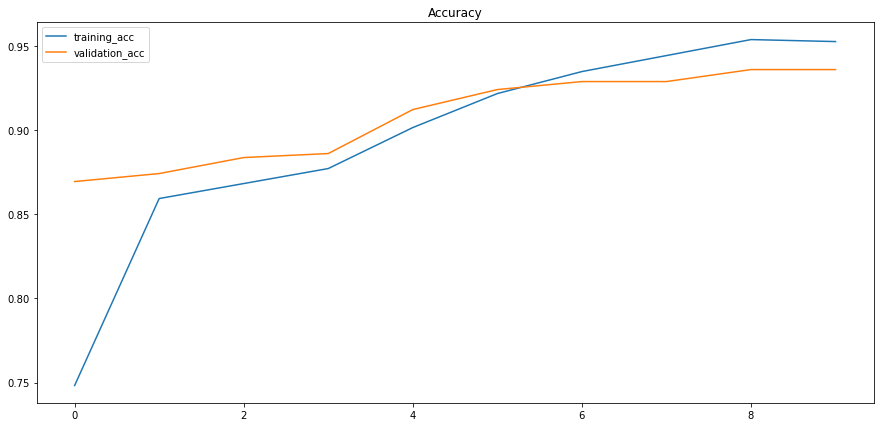

In [36]:
#plot accuracy
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

## GRU model

In [37]:
emb_dim = embedding_matrix.shape[1]
gru_model = Sequential()
gru_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation = 'sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
gru (GRU)                    (None, 128)               165120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 3,165,249
Trainable params: 165,249
Non-trainable params: 3,000,000
_________________________________________________________________
None


In [38]:
batch_size = 256
epochs  = 10
history = gru_model.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)

Epoch 1/10
7/7 [==============================] - 16s 1s/step - loss: 0.4814 - accuracy: 0.8189 - val_loss: 0.3740 - val_accuracy: 0.8717
Epoch 2/10
7/7 [==============================] - 8s 1s/step - loss: 0.3989 - accuracy: 0.8640 - val_loss: 0.3357 - val_accuracy: 0.8812
Epoch 3/10
7/7 [==============================] - 8s 1s/step - loss: 0.3496 - accuracy: 0.8741 - val_loss: 0.3097 - val_accuracy: 0.8884
Epoch 4/10
7/7 [==============================] - 10s 1s/step - loss: 0.3212 - accuracy: 0.8848 - val_loss: 0.2889 - val_accuracy: 0.8931
Epoch 5/10
7/7 [==============================] - 10s 1s/step - loss: 0.2744 - accuracy: 0.8949 - val_loss: 0.2650 - val_accuracy: 0.8931
Epoch 6/10
7/7 [==============================] - 9s 1s/step - loss: 0.2181 - accuracy: 0.9175 - val_loss: 0.2282 - val_accuracy: 0.9145
Epoch 7/10
7/7 [==============================] - 9s 1s/step - loss: 0.1875 - accuracy: 0.9329 - val_loss: 0.2506 - val_accuracy: 0.9192
Epoch 8/10
7/7 [======================

Text(0.5, 1.0, 'Accuracy')

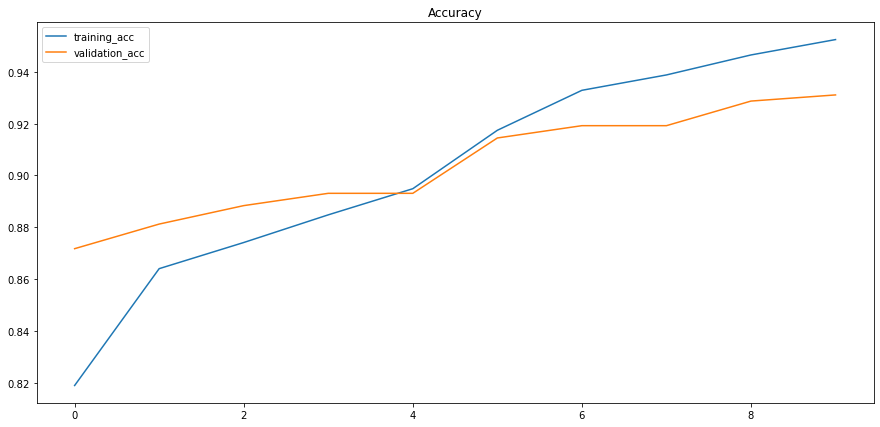

In [39]:
#plot accuracy
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

In [40]:
train_gru_results = gru_model.evaluate(xtrain_pad, np.asarray(ytrain), verbose=0, batch_size=256)
test_gru_results = gru_model.evaluate(xtest_pad, np.asarray(ytest), verbose=0, batch_size=256)
print(f'Train accuracy: {train_gru_results[1]*100:0.2f}')
print(f'Test accuracy: {test_gru_results[1]*100:0.2f}')

Train accuracy: 95.37
Test accuracy: 93.11
